In [15]:
from dicomUtils import *
import matplotlib.pyplot as plt
def imshow_single(img, title):
    fig,ax = plt.subplots()
    ax.imshow(img,cmap='gray')
    ax.set_title(title)
    plt.axis('off')
def imshow_double(img1, img2, title):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(img1,cmap='gray')
    ax2.imshow(img2,cmap='gray')
    plt.axis('off')
    fig.suptitle(title, fontsize=16)
def get_sample_in_volume(sample_dir):
    sv = getVolume(sample_dir)
    volume_data = sv.raw_data
    volume_data.shape
    img = volume_data[:,:,int(volume_data.shape[-1] / 2.0)]
    return img.astype(np.uint16)

#     imshow_single(img,sample_dir + "original slice")

In [16]:
sample_volume = []
sample_volume_names = []
dataset_path = '../data/PACS/IRB02/'
index_file = dataset_path + 'index.txt'
with open(index_file) as f:
    lines = f.readlines()
    for line in lines:
        name = line.split(',')[0]
        img = get_sample_in_volume(dataset_path+name)
        sample_volume.append(img)
        sample_volume_names.append(name)

IndexError: list index out of range

In [5]:
sample_vol_name = '../data/PACS/IRB02/2200_FATPOSTCORLAVAFLEX2/'
name_lst = listdir(sample_vol_name)

In [6]:
inf = pydicom.dcmread(sample_vol_name + name_lst[0])
inf

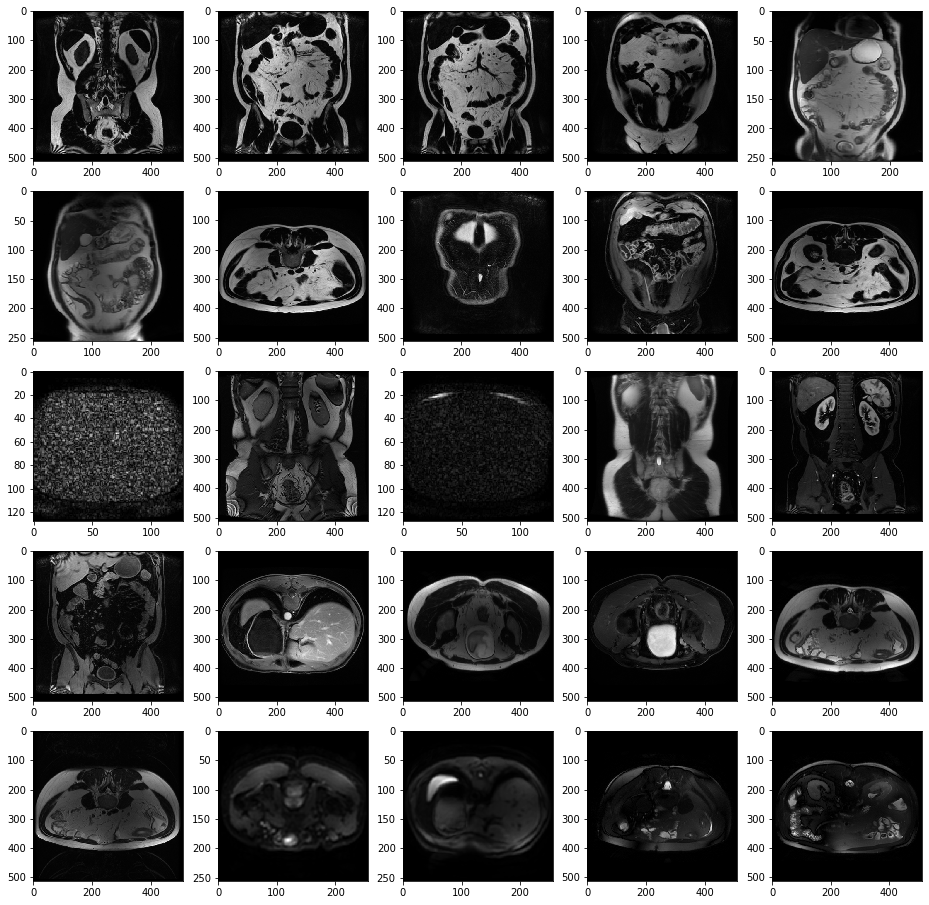

In [4]:
fig=plt.figure(figsize=(16, 16))
columns = 5
rows = 5
for i in range(len(sample_volume)):
    img = sample_volume[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img,cmap='gray')
plt.show()

In [5]:
# from generateIndexFile import get_vol_folder_name_lst
# # dataset_path = '../data/PACS/IRB02/'
# contents = []
# sort_base = []
# for foldername in listdir(dataset_path):
#     folderpath = path.join(dataset_path, foldername)
#     if not path.isdir(folderpath):
#             continue
#     print("process: " +folderpath)
#     vol_names = get_vol_folder_name_lst(dataset_path, foldername)
#     for vol_name in vol_names:
#         vol_path = path.join(dataset_path, vol_name)
#         print(vol_path)
#         # img_width, img_height, dcm_num, vol_thickness = getVolumeDimensions(vol_path)
#         vd = getVolume(vol_path)
#         if(vd == None):
#             print("==vd invalid==")
#             continue
#         img_height, img_width, dcm_num = vd.raw_data.shape
#         vl_mask_path = path.join(vol_path, 'mask')
#         mask_available = path.exists(vl_mask_path) and path.isdir(vl_mask_path) and len(glob(vl_mask_path+'/*.png')) == dcm_num
#         # mask_available = path.isdir(mskpath) and path.isdir(path.join(mskpath, folder)) and len(glob(path.join(mskpath, folder, '*.png'))) == dcm_num
#         scores = getScore(vd)
#         qscore = int(mask_available)*100 + scores[-1]
# #         content = get_content_str_array("", [vol_name, dcm_num, img_height, img_width, vd.vol_thickness, mask_available, scores, qscore])[:-1]
# #         content+= "\n"
#         contents.append(vol_name)
#         sort_base.append(scores[0])
# sorted_list = [x for _, x in sorted(zip(sort_base,contents), key=lambda pair: pair[0], reverse=True)]

In [91]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
window = (13, 13)

def getPreprocessImages(img_12bit):
    img_8bit = img_12bit * 0.06227106227106227
    ori_img = img_8bit.astype(np.uint8)
    img = cv2.equalizeHist(ori_img)

    diffusion = anisodiff(img,20,50,0.1)
    mu,sigma = norm.fit(diffusion)
    htr = apply_hysteresis_threshold(diffusion,mu,sigma).astype(int)
    pmask = binary_fill_holes(htr)
    mask = cv2.morphologyEx(pmask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    if (np.sum(mask) / (mask.shape[0] * mask.shape[1]) < 0.2):
        return []
#     [fg,bg]=foregroundBackground(mask, ori_img)
    fore_image = mask * ori_img
    back_image = (1 - mask) * ori_img
    mask_bool = mask.astype(bool)
    
    #normalize image
#     F = cv2.normalize(fore_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return [fore_image, back_image, mask, ori_img[mask_bool], img[mask_bool==False]]


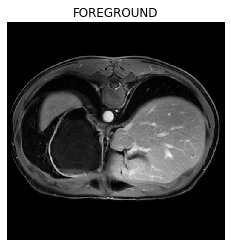

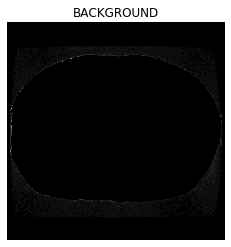

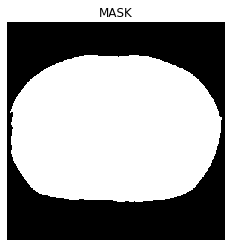

In [331]:
res=getPreprocessImages(sample_volume[16])
if(len(res) == 0):
    print("wrong")
[F, B, c, f, b] = res
# imshow_double(F,B,"FORE-BACKGROUND")
imshow_single(F,"FOREGROUND")
imshow_single(B,"BACKGROUND")
imshow_single(c,"MASK")
# c.dtype
# np.unique(np.array(f))


In [230]:
from skimage.util import pad
from skimage.filters import median
from skimage.morphology import square
from scipy.signal import convolve2d as conv2
from skimage.morphology import convex_hull_image
def mean(F, B, c, f, b):
    return np.nanmean(f)

def rang(F, B, c, f, b):
    return np.ptp(f)

def variance(F, B, c, f, b):
    return np.nanvar(f)

def percent_coefficient_variation(F, B, c, f, b):
    return (np.nanstd(f)/np.nanmean(f))*100

def contrast_per_pixle(F, B, c, f, b):
    filt = np.array([[ -1/8, -1/8, -1/8],[-1/8, 1, -1/8],[ -1/8, -1/8,  -1/8]])
    I_hat = conv2(F, filt, mode='same')
    return np.nanmean(I_hat)

def psnr(img1, img2):
    mse = np.square(np.subtract(img1, img2)).mean()
    return 20 * np.log10(np.nanmax(img1) / np.sqrt(mse))

def fpsnr(F, B, c, f, b):
    I_hat = median(F/np.max(F), square(5))
    return psnr(F, I_hat)

def snr1(F, B, c, f, b):
    return np.nanstd(f) / np.nanstd(b)

def patch(img, patch_size):
    h = int(np.floor(patch_size / 2))
    U = pad(img, pad_width=h, mode='constant')
    [a,b]  = np.where(img == np.max(img))
    a = a[0]
    b = b[0]
    return U[a:a+2*h+1,b:b+2*h+1]

def snr2(F, B, c, f, b):
    fore_patch = patch(F, 5)
    return np.nanmean(fore_patch) / np.nanstd(b)

def snr3(F, B, c, f, b):
    fore_patch = patch(F, 5)
    return np.nanmean(fore_patch)/np.nanstd(fore_patch - np.nanmean(fore_patch))

def snr4(F, B, c, f, b):
    fore_patch = patch(F, 5)
    back_patch = patch(B, 5)
    return np.nanmean(fore_patch) / np.nanstd(back_patch)

def cnr(F, B, c, f, b):
    fore_patch = patch(F, 5)
    back_patch = patch(B, 5)
    return np.nanmean(fore_patch-back_patch) / np.nanstd(back_patch)

def cvp(F, B, c, f, b):
    fore_patch = patch(F, 5)
    return np.nanstd(fore_patch) / np.nanmean(fore_patch)

def cjv(F, B, c, f, b):
    return (np.nanstd(f) + np.nanstd(b)) / abs(np.nanmean(f) - np.nanmean(b))

def efc(F, B, c, f, b):
    n_vox = F.shape[0] * F.shape[1]
    efc_max = 1.0 * n_vox * (1.0 / np.sqrt(n_vox)) * \
        np.log(1.0 / np.sqrt(n_vox))
    cc = (F**2).sum()
    b_max = np.sqrt(abs(cc))
    return float((1.0 / abs(efc_max)) * np.sum(
        (F / b_max) * np.log((F + 1e16) / b_max)))

def fber(F, B, c, f, b):
    fg_mu = np.nanmedian(np.abs(f) ** 2)
    bg_mu = np.nanmedian(np.abs(b) ** 2)
    if bg_mu < 1.0e-3:
        return 0
    return float(fg_mu / bg_mu)
def fb_ratio(F, B, c, f, b):
    return len(f)/len(b)
def moment(F, B, c, f, b):
    # contrast feature img
    maximg = maximum_filter(F, size = window)
    minimg = minimum_filter(F, size = window)
    contrast_img = maximg - minimg
    # image moment
    Fscale_moment = cv2.moments(F)['nu20']
    contrast_moment = cv2.moments(contrast_img)['nu20']
    # binary image
    fgmg = (F > Fscale_moment).astype(np.int)
    fcmg = (F > contrast_moment).astype(np.int)
    fcmc = (contrast_img > contrast_moment).astype(np.int)
    fgmc = (contrast_img > Fscale_moment).astype(np.int)
     # luminance contrast quality score
    q11 = fcmg & fgmg
    q1 = np.sum(c * q11) / max(np.sum(fcmg), np.sum(fgmg)) if max(np.sum(fcmg), np.sum(fgmg)) != 0 else 0

    # texture score
    q22 = fgmc & fcmc
    q2 = np.sum(c * q22) / max(np.sum(fgmc), np.sum(fgmg)) if max(np.sum(fgmc), np.sum(fgmg)) != 0 else 0

    # texture contrast quality score
    q33 = fgmc & fcmc
    q3 = np.sum(c * q33) / np.sum(c) if np.sum(c) != 0 else 0

    # lightness quality score
    q44 = fcmg & fgmg
    q4 = np.sum(c * q44) / np.sum(c) if np.sum(c) != 0 else 0

    # print(f"{q1},{q2},{q3},{q4}")
    # weight
    w1 = w2 = w4 = 0.1
    w3 = 0.7
    Q = w1 * q1 + w2 * q2 + w3 * q3 + w4 * q4
    return Q
def exceed_penalty(F,B,c,f,b):
    PW = 2
    chull = convex_hull_image(c)
    (rows, cols) = chull.shape
    wrong_pix_num = np.sum(chull[:PW, :]==1) + np.sum(chull[rows-PW:, :]==1) + np.sum(chull[PW:rows-PW,:PW] == 1) + np.sum(chull[PW:rows-PW,cols-PW:] == 1)
    overall = PW * rows * 2+  PW * cols*2 - 4*PW*PW
    return (1.0 - wrong_pix_num/overall)


In [231]:
 measure_func={
            'Mean': mean,
            'Range': rang,
            'Variance': variance, 
            'CV': percent_coefficient_variation,
            'CPP': contrast_per_pixle,
            'PSNR': fpsnr,
            'SNR1': snr1,
            'SNR2': snr2,
            'SNR3': snr3,
            'SNR4': snr4,
            'CNR': cnr,
            'CVP': cvp,
            'CJV': cjv,
            'EFC': efc,
            'FBER': fber,
             'FBRATIO':fb_ratio,
            'MOMENT':moment,
            'EXCEED':exceed_penalty,
            }
'''
Input: image should be of the original value: 12bit
Output: a series of measurements for a single image
'''
def getSingleImageMeasurements(image, func_lst=[]):
    M = []
    res=getPreprocessImages(image)
    if len(res) == 0:
        return []
    #unpack res
    [F,B,c,f,b] = res
    if np.std(F) == 0:  # whole zero slice, no measure computing
        return []
    if len(func_lst) == 0:
        func_lst = measure_func.keys()
    for key in func_lst:
        func=measure_func.get(key)
        measure = func(F, B, c, f, b)
        if np.isnan(measure) or np.isinf(measure):
            M.append(0)
        else:
            M.append(measure)
    return M
'''
Input: volume is volue raw data
Output: dictionary that contains index and corresponding measurement
'''
def getScoreForSlicesInVolume(volume_raw, sample_ids = [], func_lst=[]):
    Ms = {} 
    if volume_raw.ndim < 3:
        Ms[0] = getSingleImageMeasurements(volume_raw)
        return Ms
    vol_dim = volume_raw.shape[-1]
    
    #volume polution
    MAX_POLLUTED = int(vol_dim / 4)
    polutted_num = 0
    
#     sel_image_ids = []
#     #todo:naive sample
#     if sampled and vol_dim > 5:
#         mid = int(vol_dim / 2.0)
#         sel_image_ids = [mid-2, mid, mid+2]
#     else:
#         sel_image_ids = range(vol_dim)
    print("sampled:" + str(sample_ids))
    if len(func_lst) == 0:
        func_lst = measure_func.keys()
        
    if len(sample_ids) == 0:
        sample_ids = range(vol_dim)
    for i in sample_ids:
        measures =  getSingleImageMeasurements(volume_raw[:,:,i], func_lst)
        if len(measures) == 0:
            if polutted_num > MAX_POLLUTED:
                return {}
            polutted_num+=1
        else:
            Ms[i] = measures
    return Ms
    

In [232]:
# getSingleImageMeasurements(sample_volume[16])
sv_sample = getVolume(dataset_path + sample_volume_names[16])
sv_sample_raw_data = sv_sample.raw_data
Ms = getScoreForSlicesInVolume(sv_sample_raw_data, sample_ids = [0, int(sv_sample_raw_data.shape[-1] / 2)], func_lst=['EXCEED'])
print(Ms[0])
print(Ms[54])

sampled:[0, 54]
[1.0]
[1.0]


In [229]:
[F16, B16, c16, f16, b16]=getPreprocessImages(sample_volume[16])
# [F10, B10, c10, f10, b10]=getPreprocessImages(sample_volume[10])
print(len(f16))
print(len(b16))

143410
118734


In [98]:
print(snr1(F10, B10, c10, f10, b10))
print(snr1(F16, B16, c16, f16, b16))

0.009203786053198115
0.8498366193003469


In [335]:
def imshow_25(sup_title, images, titles):
    fig=plt.figure(figsize=(16, 16))
    columns = 5
    rows = 5
    for i in range(len(images)):
        img = images[i]
        ax=fig.add_subplot(rows, columns, i+1)
        ax.title.set_text(titles[i])#('{:.4f}'.format(titles[i]))
        plt.axis('off')
        plt.imshow(img,cmap='gray')
    fig.suptitle(sup_title, fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.show()
    plt.savefig('save.png')

In [235]:
scores_raw = []
for sslice in sample_volume:
    scores_raw.append(getSingleImageMeasurements(sslice))#,func_lst=['EFC'])))

In [248]:
score_norm = []
scores_np = np.array(scores_raw)
max_vs = [np.max(scores_np[:,x]) for x in range(scores_np.shape[-1])]
print(max_vs)
for scores in scores_raw:
    score_norm.append([u/v for u,v in zip(scores, max_vs)])

[70.12828581582235, 255.0, 3017.696240142051, 140.94082989925332, 0.06622695922851562, 24.999709389655486, 3.7188145025638484, 12.32171135411195, 37.35743404789864, 38.111341255858285, 37.32443416282321, 0.8682536766906326, 244.12982617262247, 24.532735546324904, 3.4242424242424243, 4.383828633628391, 0.9937852296279246, 1.0]


In [249]:
test = [1,2,3]
max(test)

3

In [337]:
smean_norm = [np.mean(x) for x in score_norm]
smean_raw = [np.mean(x) for x in scores_raw]
sorted_raw_imgs = [img for _, img in sorted(zip(smean_raw,sample_volume), key=lambda pair: pair[0], reverse=True)]
sorted_norm_values = [x for _, x in sorted(zip(smean_raw,smean_norm), key=lambda pair: pair[0], reverse=True)]
sorted_vol_names = [x for _, x in sorted(zip(smean_raw,sample_volume_names), key=lambda pair: pair[0], reverse=True)]
sorted_mean_raw = sorted(smean_raw, reverse=True)

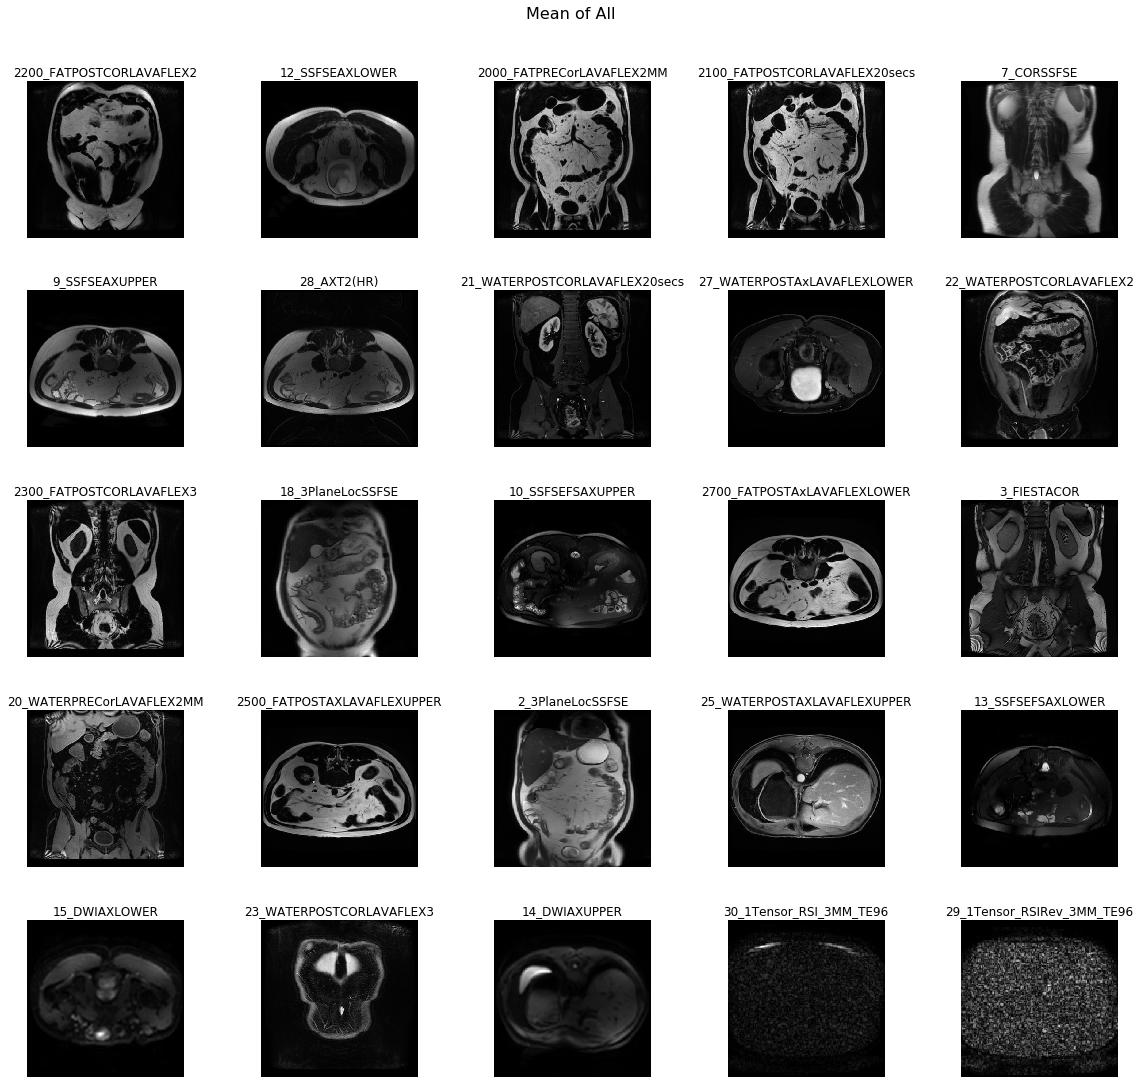

In [338]:
imshow_25('Mean of All',sorted_raw_imgs, sorted_vol_names)

In [339]:
sorted_mean_raw_np = np.array(sorted_mean_raw)
sorted_raw_imgs_np = np.array(sorted_raw_imgs)
sorted_norm_values_np = np.array(sorted_norm_values)
sorted_vol_names_np = np.array(sorted_vol_names)

c = [sorted_raw_imgs_np[index] for index in np.where(sorted_mean_raw_np>50)]
sel_img_lst = c[0]

sel_name_lst = [sorted_vol_names_np[index] for index in np.where(sorted_mean_raw_np>50)]
sel_name_lst = sel_name_lst[0]

rule_out_lst = [sorted_raw_imgs_np[index] for index in np.where(sorted_mean_raw_np<=50)]
rule_out_lst = rule_out_lst[0]
rule_name_lst = [sorted_vol_names_np[index] for index in np.where(sorted_mean_raw_np<=50)]
rule_name_lst = rule_name_lst[0]

sel_mean_norm = [sorted_norm_values_np[index] for index in np.where(sorted_mean_raw_np>50)] 
sel_mean_norm = sel_mean_norm[0]

In [347]:
#order sel img based on normed value
sorted_final_imgs = [img for _, img in sorted(zip(sel_mean_norm,sel_img_lst), key=lambda pair: pair[0], reverse=True)]
sorted_names = [name for _, name in sorted(zip(sel_mean_norm,sel_name_lst), key=lambda pair: pair[0], reverse=True)]

sel_mean_norm_sorted = sorted(sel_mean_norm, reverse=True)

In [346]:
contact_images = sorted_final_imgs
contact_images.extend(rule_out_lst)
len(sorted_final_imgs)

25

In [348]:
sorted_names.extend(rule_name_lst)
len(sorted_names)

7

In [349]:
len(sorted_names)

25

In [358]:
sel_mean_norm_sorted = sel_mean_norm_sorted+[0]*7

In [359]:
len(sel_mean_norm_sorted)

25

25


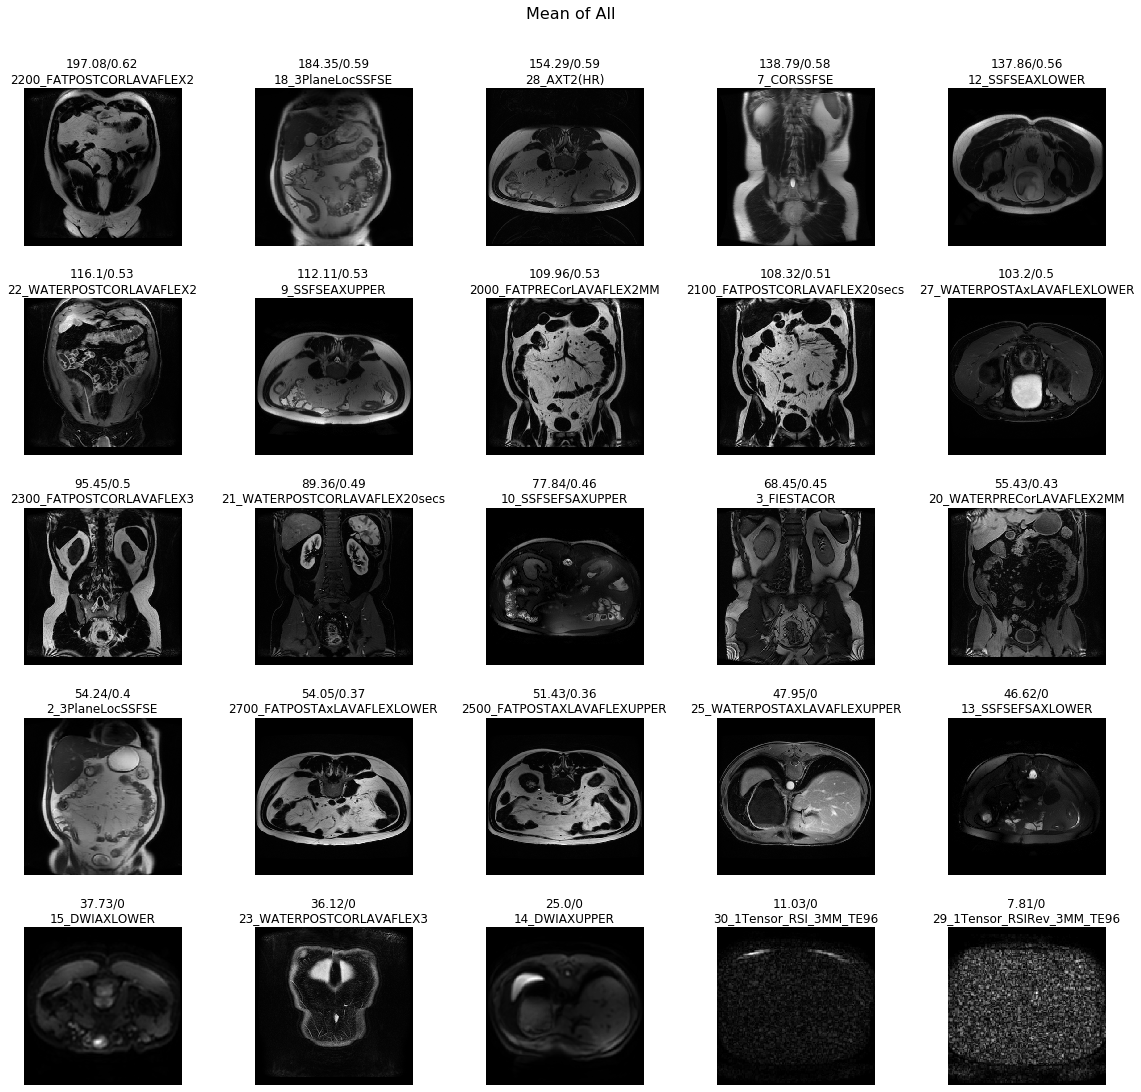

In [360]:
titles = [str(round(mr, 2))+'/'+str(round(mn, 2)) + '\n' + str(name) for mr, mn,name in zip(sorted_mean_raw, sel_mean_norm_sorted,sorted_names)]
print(len(sel_mean_norm_sorted))
imshow_25('Mean of All',contact_images, titles)

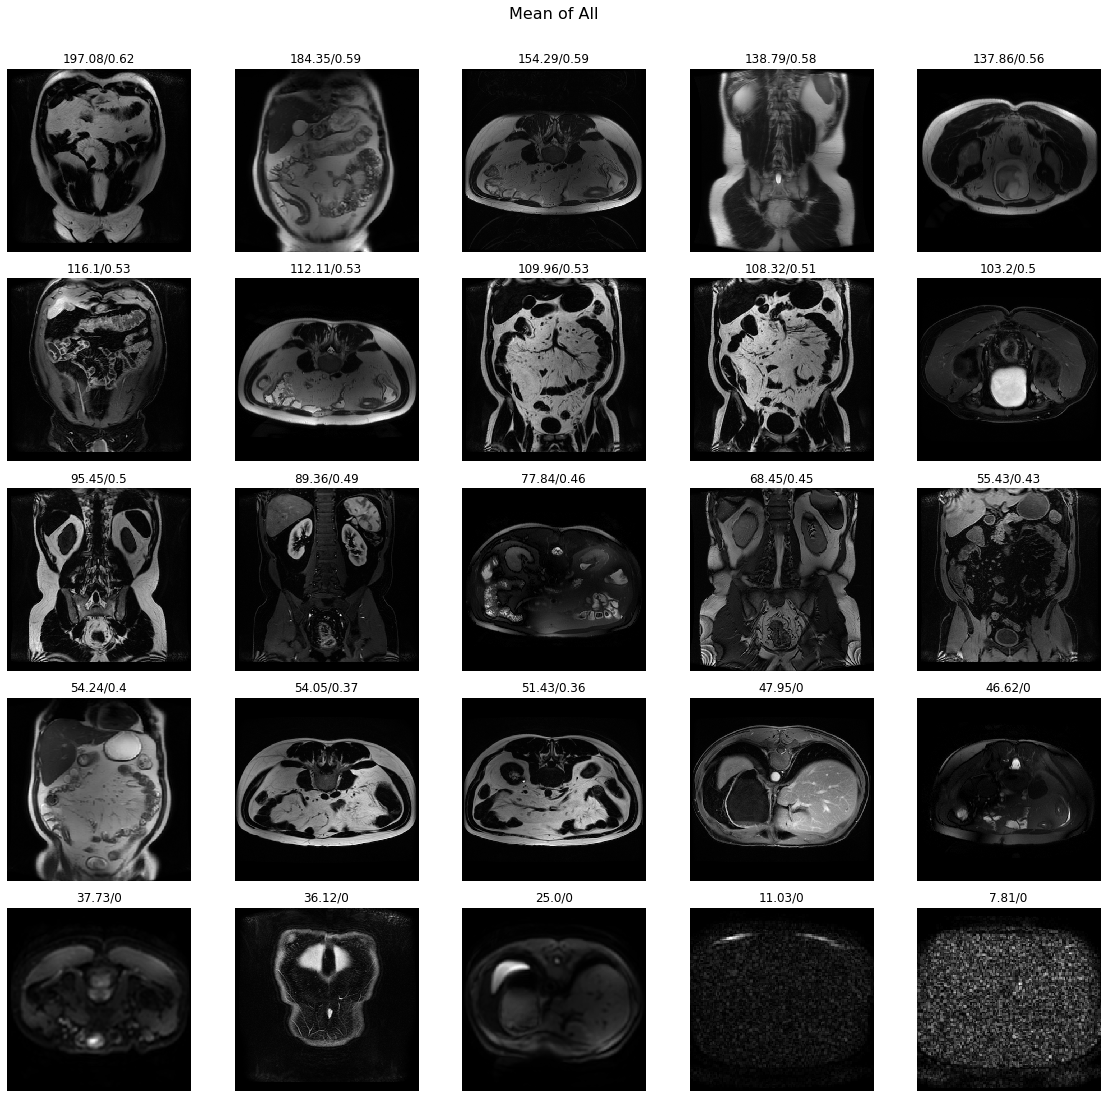

In [336]:
#mean of all

# sorted_mean_imgs = [img for _, img in sorted(zip(smean,sample_volume), key=lambda pair: pair[0], reverse=True)]
# sorted_mean = sorted(smean, reverse=True)
titles = [str(round(mr, 2))+'/'+str(round(mn, 2)) for mr, mn in zip(sorted_mean_raw, sel_mean_norm_sorted)]
imshow_25('Mean of All',sorted_final_imgs, titles)

[70.12828581582235, 255.0, 3017.696240142051, 140.94082989925332, 0.06622695922851562, 24.999709389655486, 3.7188145025638484, 12.32171135411195, 37.35743404789864, 38.111341255858285, 37.32443416282321, 0.8682536766906326, 244.12982617262247, 24.532735546324904, 3.4242424242424243, 0.9937852296279246, 1.0]


In [ ]:
#mean of all
smean = [x[0] for x in scores_raw]
sorted_mean_imgs = [x for _, x in sorted(zip(smean,sample_volume), key=lambda pair: pair[0], reverse=True)]
sorted_mean = sorted(smean, reverse=True)
imshow_25('Mean of All',sorted_mean_imgs, sorted_mean)

In [189]:
convexs = []
for sslice in sample_volume:
    [F,B,c,f,b]=getPreprocessImages(sslice)
    convexs.append(c)
    
# fig=plt.figure(figsize=(16, 16))
# columns = 5
# rows = 5
# for i in range(len(convexs)):
#     img = convexs[i]
#     fig.add_subplot(rows, columns, i+1)
#     plt.imshow(img,cmap='gray')
# plt.show()